# NZ Seek Data Jobs Analysis

## Data Reprocessing

### 1. Import library

In [341]:
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_colwidth',-1)

In [342]:
Dict_title_index = {'Admin':0,'Bank':0}
Dict_company_index = {'Admin':2,'Bank':2}
Dict_seek_index = {'Admin':1,'Bank':1}
Dict_post_index = {'Admin':4,'Bank':5}
Dict_location_index = {'Admin':3,'Bank':3}
Dict_classification_index = {'Admin':5,'Bank':4}
Dict_salary_index = {'Admin':5,'Bank':6}

Dict_minsalary_num = {'Admin':45000,'Bank':65000}
Dict_maxsalary_num = {'Admin':75000,'Bank':100000}

### 2. Values

### 2-0 Help function

In [343]:
# Function to clean duplicated text
def delduplicated(x):
    sentence=x.strip()
    index=(sentence+sentence).find(sentence,1)
    if index!=-1:
        return sentence[:index]
    else:
        return 'Unknown'
    
# Function to get salary from classification col having salary
def detect_salary(df,class_index_incsalary):
    for index,row in enumerate(df[class_index_incsalary]):
        if 'classification:' in row:
            df.loc[index,'Salary'] = 'Unknown'
        else:
            df.loc[index,'Salary'] = row
#             df.loc[index,class_index_incsalary]='Unknown'
    return df['Salary']
    
# Unify post time 
def time_transfer(x):
    if 'd' in x:
        return -int(x[:-1])
    elif 'm' in x:
        return -(int(x[:-1])*30)
    elif x =='Unknown':
        return 'Unknown'
    else:
        return 0
    
# Function using to compare min_salary and max_salary for telling which should include k value
def tell_k_value(df):
    if (df['Max_salary']/df['Min_salary'])>=1000:
        df['Min_salary'] = df['Min_salary']*1000
    return df

### 2-1 Get possible useful info from url

In [344]:
def seek_link(df,seek_index):
    df[["Job_ID","Search_Type"]]=df[seek_index].str.extract('job/(.+?)?type=(\w+)',expand=True) 
    df['Job_ID'] = df['Job_ID'].str.replace('?','').astype(int)
    return df

### 2-2 Get post time

In [345]:
### Clean Original post_time,get job's posted time
def get_postime(df, post_index):
    df[['Post_Time(h)','Featured_at']]=df[post_index].str.split(',',expand=True)[[0,2]]

    df['Post_Time(h)']=df['Post_Time(h)'].str.extract('(\d+\w)')
    df['Post_Time(h)'].fillna('Unknown',inplace=True)
    df['Post_Time(h)']=df['Post_Time(h)'].astype('str')
    df['Post_Time(h)']=df['Post_Time(h)'].apply(time_transfer)
    return df

### 2-3 Get Location and Area

In [346]:
# Clean Original location info, get location and area info
def clean_location(df,location_index):
    df[['Location','Area']]=df[location_index].str.split('area: ',expand=True)
    df['Area']=df['Area'].str.split(',',expand=True)[0]
    
    df['Location'] = [x[10:] for x in df['Location']]
    df['Location'] = df['Location'].apply(delduplicated)
    
    df['Area'].fillna('Unknown',inplace=True)
    df['Area'] = df['Area'].apply(delduplicated)
    
    return df
    

### 2-4 Get Classification and subclassification

In [347]:
# get salary from classification col
def get_sal_fromclass(df,class_index_incsalary):
#     get salary from classification col
    df['Salary'] = detect_salary(df,class_index_incsalary)
    
    return df

In [348]:
# Get classification and sub from classification col
def clean_classification(df,class_index):
#     get salary from classification col
#     df['Salary'] = detect_salary(df,class_index)
# clean classification and subclassi
    for index,row in enumerate(df[class_index]):
        if 'classification:' not in row:
            df.loc[index,class_index]='Unknown'
        
        
    df[['Classification','Subclassification']]=df[class_index].str.split('subClassification: ',expand=True)
    df['Classification'] = [x[16:] for x in df['Classification']]
    
    df['Classification']=df['Classification'].apply(delduplicated)

    df['Subclassification'].fillna('Unknown',inplace=True)
    df['Subclassification']=df['Subclassification'].apply(delduplicated)
    
    return df


### 2-5 Get Salary

In [404]:
def clean_salary(df,min_num,max_num):

    # get holiday pay
    df['Plus']=df['Salary'].str.extract('(\d+%)')
    df['Plus'].fillna('Unkown',inplace=True)

    df['Salary']= df[df['Salary'].str.contains('\d')]['Salary'].str.replace('to','-')
    df['Salary']=df[df['Salary'].str.contains('\d',na=False)]['Salary'].str.replace('\d+%','',regex=True)
    
    #split range from salary
    df[['Min_salary','Max_salary']]=df['Salary'].str.split('-',n=1,expand=True).fillna('Unkown')
    df[['Min_salary','Max_salary']].fillna('Unkown',inplace=True)
    
    # clean min and max salary, unify format
    df['Min_salary'] = df['Min_salary'].str.replace(',','')
    df['Max_salary'] = df['Max_salary'].str.replace(',','')
    
    # extract salary num having '. k ' and remove space between num
    df['Min_salary'] = df['Min_salary'].str.extract('(\d+\.\+\d|\d+ \d+|\d+[kK]|\d+)')
    df['Max_salary'] = df['Max_salary'].str.extract('(\d+\.\+\d|\d+ \d+|\d+[kK]|\d+)')
    df['Min_salary'] = df['Min_salary'].str.replace(' ','')
    df['Max_salary'] = df['Max_salary'].str.replace(' ','')
    
    # get the indexes of num which having 'k' from max col 
    # replace k to 000 in both min/max cols
    df['Max_salary']=df[df['Max_salary'].str.contains('\d',na=False)]['Max_salary'].str.replace('k|K','000',regex=True)
    df['Min_salary']=df[df['Min_salary'].str.contains('\d',na=False)]['Min_salary'].str.replace('k|K','000',regex=True)

    df['Min_salary']=df['Min_salary'].fillna('Unkown')
    df['Max_salary']=df['Max_salary'].fillna('Unkown')
    
    # to fulfill null salary in min/max salary col
    for i, row in enumerate(df['Min_salary']):
        if row=='Unkown':
            df.loc[i,'Min_salary']=np.random.randint(min_num,max_num,size=1)[0]
            
    for i, row in enumerate(df['Max_salary']):
        if row=='Unkown':
            df.loc[i,'Max_salary']=max(np.random.randint(min_num,max_num,size=1)[0],float(df['Min_salary'][i]))
            
            
    # Unify min/max salary cols values' format 
    df['Min_salary']=df['Min_salary'].astype('float32')
    df['Max_salary']=df['Max_salary'].astype('float32')
    
    #find salary including k and unify min/max salarys with k
    df['Min_salary']=df.apply(tell_k_value,axis=1)['Min_salary']
    
    # add holiday pay plus to each job's salary needed
    for i, row in enumerate(df['Plus']):
        if row != 'Unkown':
            df.loc[i,'Min_salary']=(float(df['Plus'][i][:-1])/100+1)*df.loc[i,'Min_salary']
            df.loc[i,'Max_salary']=(float(df['Plus'][i][:-1])/100+1)*df.loc[i,'Max_salary']
     
    # transfer min/max salary cols into annual base value
    df.loc[(df['Min_salary']/100)<=10,'Min_salary']=df['Min_salary']*8*200
    df.loc[(df['Max_salary']/100)<=10,'Max_salary']=df['Max_salary']*8*200
    
    
    
    return df

### 2-6 Rename other cols and fulfill company col with 'Featured at' col


In [350]:
def rename_col(df,title_index,company_index,seek_index,post_index,location_index,class_index_incsalary,class_index):
    df.rename(columns={title_index:'Job_Title',company_index:'Company'},inplace=True)
    df['Company'].fillna(df['Featured_at'],inplace=True)
    # Delete redundant cols 
    df.drop(['Featured_at'],axis=1,inplace=True)
    df.drop([seek_index],axis=1,inplace=True)
    df.drop([post_index],axis=1,inplace=True)
    df.drop([location_index],axis=1,inplace=True)
    
    if class_index_incsalary == class_index:
        df.drop([class_index],axis=1,inplace=True)
    else:
        df.drop([class_index_incsalary],axis=1,inplace=True)
        df.drop([class_index],axis=1,inplace=True)
            
    df.drop(['Salary'],axis=1,inplace=True)
    df.drop(['Plus'],axis=1,inplace=True)
    
    return df

## 3. Main function

In [351]:
def clean_jobfile(path,job_filename):
    df = pd.read_excel(path,header=None, skiprows=1)
    df = seek_link(df,Dict_seek_index[job_filename])
    df = get_postime(df,Dict_post_index[job_filename])
    df = clean_location(df,Dict_location_index[job_filename])
    df = get_sal_fromclass(df,Dict_salary_index[job_filename])
    df = clean_classification(df,Dict_classification_index[job_filename])
    

    df = clean_salary(df,
                      Dict_minsalary_num[job_filename],
                      Dict_maxsalary_num[job_filename])
    
    df = rename_col(df,
                    Dict_title_index[job_filename],
                    Dict_company_index[job_filename],
                    Dict_seek_index[job_filename],
                    Dict_post_index[job_filename],
                    Dict_location_index[job_filename],
                    Dict_salary_index[job_filename],
                    Dict_classification_index[job_filename])
    return df

In [439]:
df_admin = clean_jobfile('NZ_Admin_JOBS.xlsx','Admin')
df_bank = clean_jobfile('NZ_Banking_JOBS.xlsx','Bank')

In [468]:
df_admin.head(50)

,Job_Title,Company,Job_ID,Search_Type,Post_Time(h),Location,Area,Classification,Subclassification,Min_salary,Max_salary
0,Administrator,Private Advertiser,50582301,promoted,Unknown,Bay of Plenty,Tauranga,Administration & Office Support,Office Management,64772.0,64772.0
1,Receptionist,Avenues Orthodontics,50620889,promoted,Unknown,Bay of Plenty,Tauranga,Administration & Office Support,Receptionists,52432.0,52432.0
2,Prosecutions Support Officer,New Zealand Police,50622169,standard,-4,Auckland,Unknown,Administration & Office Support,Other,48910.0,71809.0
3,Early Childhood Centre Administrator,Kew Pacific Island Early Learning Centre,50639620,standard,0,Southland,Invercargill,Administration & Office Support,Administrative Assistants,67641.0,67641.0
4,Business Support Administrator,Private Advertiser,50622432,standout,-4,Canterbury,Christchurch,Administration & Office Support,Client & Sales Administration,56178.0,56178.0
5,Support Officer,Ministry for Primary Industries,50640393,standout,-270,Northland,Whangarei,Administration & Office Support,Administrative Assistants,67678.0,67678.0
6,Support Officer,"Ministry of Business, Innovation and Employment",50615674,standout,-5,Wellington,Wellington Central,Administration & Office Support,Other,60252.0,72899.0
7,office administrator,Hepburn Electrical Ltd,50640166,standard,-210,Bay of Plenty,Rotorua,Administration & Office Support,Administrative Assistants,66632.0,69175.0
8,Office Administrator,Webster Holland Ltd,50639248,standard,0,Bay of Plenty,Tauranga,Administration & Office Support,Administrative Assistants,69133.0,69133.0
9,Administration Officer,New Zealand Police,50629393,standard,-3,Canterbury,Unknown,Administration & Office Support,Other,55337.0,56673.0


# <span style='color:#FA5858'> Visualize Admin jobs data </span>
### **This project's aim is to discover the correlations or trends of features in admin job file**

In [408]:
# import used libraries
import matplotlib.pyplot as plt
import seaborn as sns

### <span style= 'color:#8A0808;font-style:italic'> (All Infos About Jobs can be retained)</span>

###  **Q1: What is the top 10 Job titles in Admin?**
---
### <span>A1: From the following bar chart, the Top 10 admin job titles are: </span>
### 1.Executive Assistant  </br>2.Temporary Office Roles  </br>3.Contracts Administrator  </br>4.Team Administrator  </br>5.Temp Receptionists/Administrators  </br>6.Sales Administrator and Support  </br>7.Category Manager   </br>8.Graduates with Office Administration Experience  </br>9.Business Professional </br> 10.Experienced Executive & Personal Assistants 

In [629]:
top10 = df_admin['Job_Title'].value_counts(sort=True).head(10)
# top10

Text(0.5, 1.0, 'Top 10 Job titles of Admin')

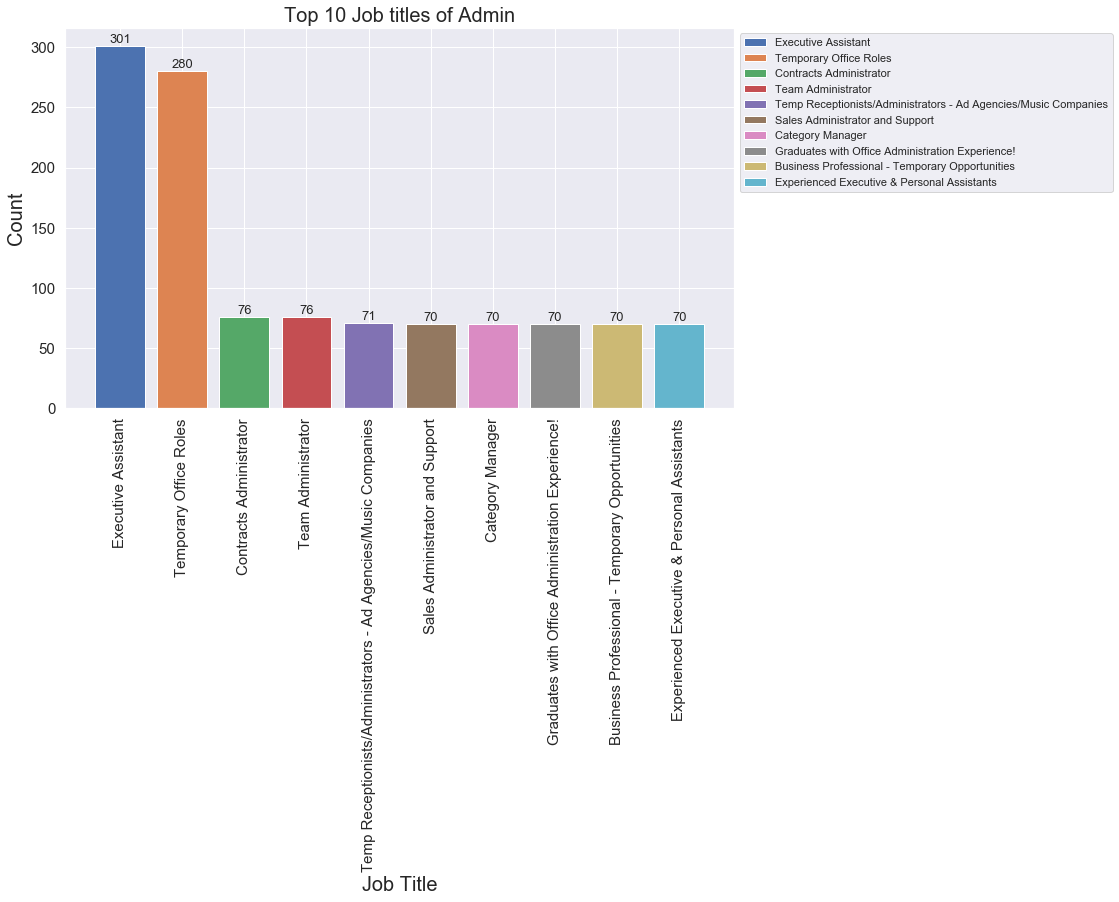

In [630]:
plt.figure(figsize=(12,7))
bar_width=0.8


for i, v in top10.items():
    plt.bar(i,v,bar_width,label=i)
    plt.text(i,v+0.5,'%.0f'%v,ha='center', va='bottom',fontsize=13) #add num to each bar to show clear

plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xticks(rotation = 90, fontsize=15) 
plt.yticks(fontsize=15)
plt.ylabel('Count',fontsize=20)
plt.xlabel('Job Title',fontsize=20)
plt.title('Top 10 Job titles of Admin',fontsize=20)


###  **Q1: What is the top 5 companies having highest demand for jobs and what is the top 3 job titles they needed most?**
---
### A1: From the following bar chart, we can know that Adecco office,Alpha Recruitment,Asset Recruitment Ltd,Beyond Recruitment,GBL Personnel has the highest demand for jobs. While looking from the bars, among these 5 firms, it is clear that Asset Recruitment Ltd has posted the most job positions on Seek, the job position with the highest demand is temporary office roles. It means that this kind of job is mobile. In addition, This job's average salary is around 59515.0 to 66415.5 per year.


In [785]:
topcompany = df_admin['Company'].value_counts(sort=True).head(5)# get top 5 companies who have the most job advertises,having the most job positions

In [632]:
highjob = df_admin[df_admin['Company'].isin(topcompany.index)][['Job_Title','Company']].groupby(['Company','Job_Title']).Job_Title.agg('count').to_frame('Count')

In [633]:
topdemand=highjob['Count'].groupby(['Company'], group_keys=False).nlargest(3).reset_index()
topdemand

,Company,Job_Title,Count
0,Adecco Office,Experienced Administrator,70
1,Adecco Office,Administrator,1
2,Adecco Office,Duty Collection Agent,1
3,Alpha Recruitment - NZ,Executive Assistant,70
4,Alpha Recruitment - NZ,Administrator with Medical Experience - Central,1
5,Alpha Recruitment - NZ,Administrator-Maori Health,1
6,Asset Recruitment Ltd,Temporary Office Roles,280
7,Asset Recruitment Ltd,Reception - Part Time,1
8,Asset Recruitment Ltd,Sales Co-Ordinator,1
9,Beyond Recruitment - Winner – Best Innovation –2018 Global Recruiter Awards,Executive Assistant,70


In [602]:
print(sns.__version__)

0.9.0


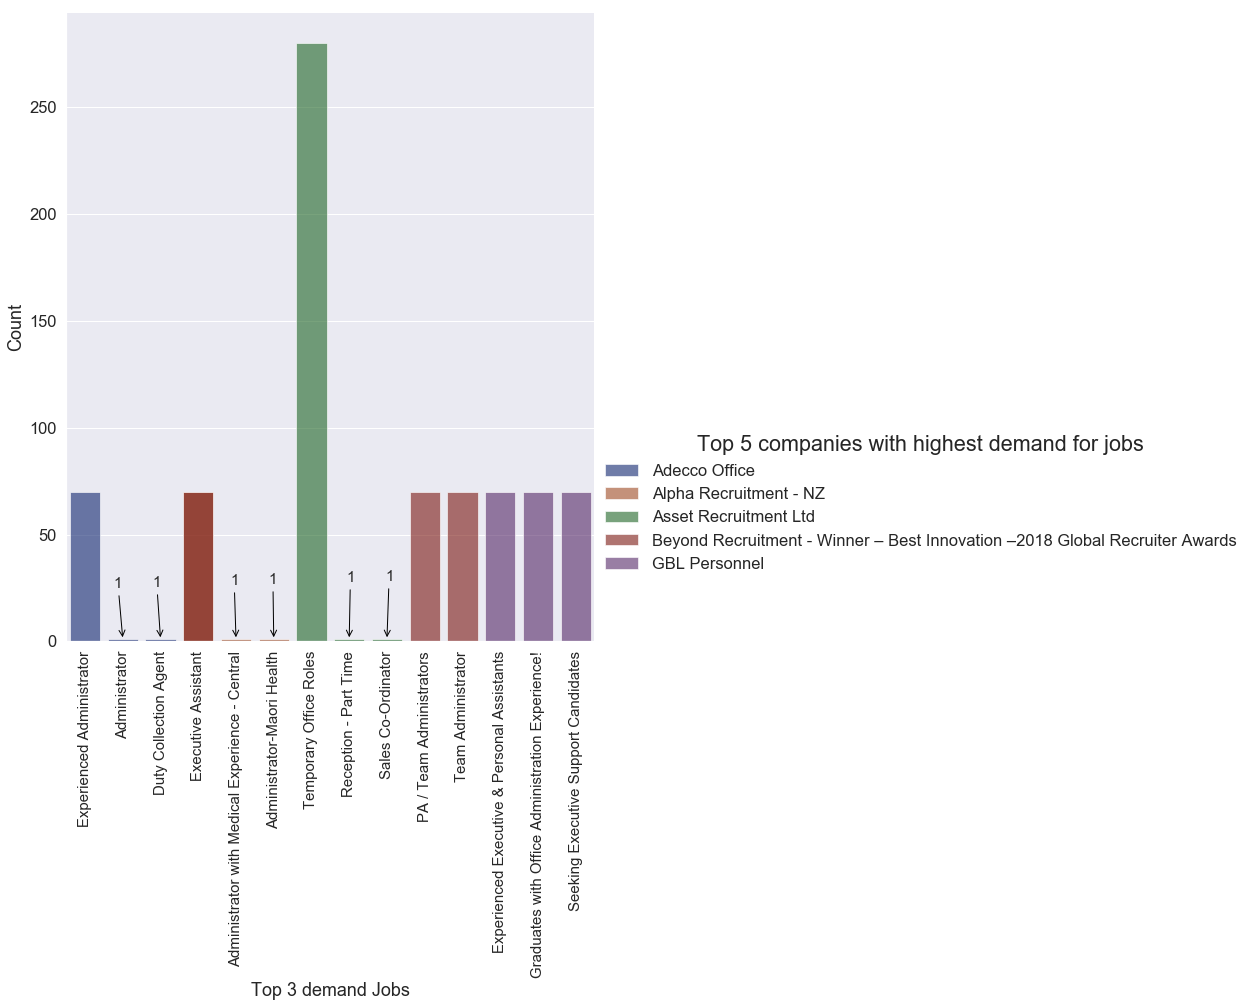

In [777]:
sns.set_style('darkgrid')
sns.set(font_scale=1.5) 

g = sns.catplot(
    data=topdemand, kind='bar',
    x='Job_Title', y='Count', hue='Company',
    ci='sd', palette='dark', alpha=.6, height=10,dodge=False
)
plt.xticks(rotation=90,fontsize=15)
g.set_axis_labels('Top 3 demand Jobs', 'Count')
g._legend.set_title("Top 5 companies with highest demand for jobs",prop={'size':'large'})

for i, row in enumerate(topdemand['Count']):
    if row < 30 :
        plt.annotate(str(row), 
                     xy=(i, row),     #the location of the arrow signal  
                     size=15,
                     xycoords='data',
                     xytext=(i-10,i+50),
                     textcoords='offset pixels',
                     arrowprops=dict(arrowstyle="->",color='black'),
                    )
    
# g.set_title("Top 5 companies & Top 3 demands for jobs")

In [784]:
df_admin[df_admin['Job_Title']=='Temporary Office Roles'][['Min_salary','Max_salary','Company','Job_Title']].groupby(['Company','Job_Title']).agg('median')

,,Min_salary,Max_salary
Company,Job_Title,,
Asset Recruitment Ltd,Temporary Office Roles,59515.0,66415.5


In [484]:
# admin_time = df_admin[['Post_Time(h)','Min_salary']]

In [787]:
# plt.hist(df_admin['Min_salary'],bins=20, facecolor='g', alpha=0.75)
# plt.xlabel('Min salary')
# plt.ylabel('Sum')
# plt.title('Minimum salary distribution of Admin')
# # plt.text(.025, .025, 'Annual salary')
# # plt.xlim(20000, 750000)
# plt.grid(True)
# plt.show()

In [786]:
# fig,axs = plt.subplots(figsize=(20,20))
# sns.scatterplot(data=admin_time[admin_time['Post_Time(h)']!= 'Unknown' ],x='Post_Time(h)',y='Min_salary')
# plt.xlim(-35, 0)
